In [1]:
################################################################################
## Keras implementation of day-ahead prediction of the ISO-NE hourly demand data.

# -----------------------------------------------------------------------------
# load original data file
# modification of the data loading procedure is needed if you have your own dataset

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
parse_dates = ['date']
df = pd.read_csv('selected_data_ISONE.csv', parse_dates=parse_dates, index_col='date')

In [3]:
# 1. get the maximum and minimum demands in 0-24 clock intervals
# 2. get the daily demand and temperature values
D_max_daily = df.groupby('date').demand.max().values
D_min_daily = df.groupby('date').demand.min().values
D = df.demand.values
T = df.temperature.values

In [4]:
# duplicate max and min daily demand values for 24 hours in a day
D_max = np.zeros(len(D))
D_min = np.zeros(len(D))

In [5]:
range(len(D))

range(0, 103776)

In [6]:
for i in range(len(D)):
    n_day = int(i/24)
    D_max[i] = D_max_daily[n_day]
    D_min[i] = D_min_daily[n_day]

In [7]:
D_max

array([16386., 16386., 16386., ..., 18123., 18123., 18123.])

In [8]:
len(D_max)

103776

In [9]:
# normalization based on peak values
D_max = D_max / 24000
D_min = D_min / 24000
D = D / 24000
T = T / 100

In [10]:
# add weekday info to the dataset
# the initial value for iter_weekday corresponds to the first day of the dataset
iter_weekday = 6
weekday = np.zeros((24*4324,))
for i in range(4324):
    mod = np.mod(iter_weekday, 7)
    for j in range(24):
        if (mod == 6) or (mod == 0):
            weekday[i*24 + j] = 0
        else:
            weekday[i*24 + j] = 1
    iter_weekday += 1

In [11]:
# add season and festival info to the dataset
import datetime
iter_date = datetime.date(2003, 3, 1)
season = np.zeros((24*4324,))
festival = np.zeros((24*4324,))
for i in range(4324):
    month = iter_date.month
    day = iter_date.day
    for j in range(24):
        if (month==4) | (month==5) | ((month==3) and (day>7)) | ((month==6) and (day<8)):
            season[i*24 + j] = 0
        elif (month==7) | (month==8) | ((month==6) and (day>7)) | ((month==9) and (day<8)):
            season[i*24 + j] = 1
        elif (month==10) | (month==11) | ((month==9) and (day>7)) | ((month==12) and (day<8)):
            season[i*24 + j] = 2
        elif (month==1) | (month==2) | ((month==12) and (day>7)) | ((month==3) and (day<8)):
            season[i*24 + j] = 3

        if (month == 7) and (day == 4):
            festival[i*24 + j] = 1
        if (month == 11) and (iter_date.weekday() == 4) and (day + 7 > 30):
            festival[i*24 + j] = 1
        if (month == 12) and (day == 25):
            festival[i*24 + j] = 1
    iter_date = iter_date + datetime.timedelta(1)

In [12]:
def data_split(D, T, D_max, D_min, season, weekday, festival, num_train_days, validation_split = 0.1):
    '''
    prepare the dataset used for training and testing of the model.
    '''
    x_1 = []
    x_21_D = []
    x_21_T = []
    x_22_D = []
    x_22_T = []
    x_23_D = []
    x_23_T = []
    x_3 = []
    x_4 = []
    x_5 = []
    x_season = []
    x_weekday = []
    x_festival = []
    y = []
    
    len_dataset = D.shape[0]
    num_sample = len_dataset-2016
    # 2016 hours (28*3 days) is needed so that we can formulate the first datapoint
    
    for i in range(2016,len_dataset):   
        # the demand values of the most recent 24 hours
        x_1.append(D[i-24:i])
        
        # multiple demand values every 24 hours within a week
        index_x_21 = [i-24, i-48, i-72, i-96, i-120, i-144, i-168]
        x_21_D.append(D[index_x_21])
        x_21_T.append(T[index_x_21])
        
        # multiple demand values every week within two months
        index_x_22 = [i-168, i-336, i-504, i-672, i-840, i-1008, i-1176, i-1344]
        x_22_D.append(D[index_x_22])
        x_22_T.append(T[index_x_22])
        
        # multiple demand values every month within several months
        index_x_23 = [i-672, i-1344, i-2016]
        x_23_D.append(D[index_x_23])
        x_23_T.append(T[index_x_23])
        
        x_3.append(T[i])
        x_4.append(D_max[i])
        x_5.append(D_min[i])
        
        y.append(D[i])
        
        # get one-hot representations of the additional information
        season_onehot = np.zeros(4)
        season_onehot[int(season[i])] = 1 
        x_season.append(season_onehot)

        weekday_onehot = np.zeros(2)
        weekday_onehot[int(weekday[i])] = 1 
        x_weekday.append(weekday_onehot)

        festival_onehot = np.zeros(2)
        festival_onehot[int(festival[i])] = 1 
        x_festival.append(festival_onehot)
        
    X_1 = np.array(x_1)
    X_21_D = np.array(x_21_D)
    X_21_T = np.array(x_21_T)
    X_22_D = np.array(x_22_D)
    X_22_T = np.array(x_22_T)
    X_23_D = np.array(x_23_D)
    X_23_T = np.array(x_23_T)
    X_3 = np.array(x_3)
    X_4 = np.array(x_4)
    X_5 = np.array(x_5)
    X_season = np.array(x_season)
    X_weekday = np.array(x_weekday)
    X_festival = np.array(x_festival)
    Y_1 = np.array(y)
    
    num_train = num_train_days * 24
    num_val = int(num_train * validation_split)
    
    X_train = []
    X_val = []
    X_test = []
    Y_train = []
    Y_val = []
    Y_test = []
    
    # we prepare 24 sets of data for the 24 sub-networks, each sub-network is aimed at forecasting the load of one hour of the next day
    for i in range(24):
        #               0                          1                         2                         3                         4                         5                         6                         7                    8                    9                    10                          11                           12                                              
        X_train.append([X_1[i:num_train:24,:24-i], X_21_D[i:num_train:24,:], X_21_T[i:num_train:24,:], X_22_D[i:num_train:24,:], X_22_T[i:num_train:24,:], X_23_D[i:num_train:24,:], X_23_T[i:num_train:24,:], X_3[i:num_train:24], X_4[i:num_train:24], X_5[i:num_train:24], X_season[i:num_train:24,:], X_weekday[i:num_train:24,:], X_festival[i:num_train:24,:]])
        X_val.append([X_1[num_train-num_val+i:num_train:24,:24-i], X_21_D[num_train-num_val+i:num_train:24,:], X_21_T[num_train-num_val+i:num_train:24,:], X_22_D[num_train-num_val+i:num_train:24,:], X_22_T[num_train-num_val+i:num_train:24,:], X_23_D[num_train-num_val+i:num_train:24,:], X_23_T[num_train-num_val+i:num_train:24,:], X_3[num_train-num_val+i:num_train:24], X_4[num_train-num_val+i:num_train:24], X_5[num_train-num_val+i:num_train:24], X_season[num_train-num_val+i:num_train:24,:], X_weekday[num_train-num_val+i:num_train:24,:], X_festival[num_train-num_val+i:num_train:24,:]])
        X_test.append([X_1[num_train+i:num_sample:24,:24-i], X_21_D[num_train+i:num_sample:24,:], X_21_T[num_train+i:num_sample:24,:], X_22_D[num_train+i:num_sample:24,:], X_22_T[num_train+i:num_sample:24,:], X_23_D[num_train+i:num_sample:24,:], X_23_T[num_train+i:num_sample:24,:], X_3[num_train+i:num_sample:24], X_4[num_train+i:num_sample:24], X_5[num_train+i:num_sample:24], X_season[num_train+i:num_sample:24,:], X_weekday[num_train+i:num_sample:24,:], X_festival[num_train+i:num_sample:24,:]])
        Y_train.append(Y_1[i:num_train:24])
        Y_val.append(Y_1[num_train-num_val+i:num_train:24])
        Y_test.append(Y_1[num_train+i:num_sample:24])

    return (X_train, X_val, X_test, Y_train, Y_val, Y_test)

In [13]:
# num_pre_days: the number of days we need before we can get the first sample, in this case: 3*28 days 
num_pre_days = 84
num_days = 1401
num_test_days = 365
num_train_days = 952
num_data_points = num_days * 24
num_days_start = num_days - num_pre_days - num_test_days - num_train_days
start_data_point = num_days_start * 24
X_train, X_val, X_test, Y_train, Y_val, Y_test = data_split(D[start_data_point: start_data_point + num_data_points], T[start_data_point: start_data_point + num_data_points], D_max[start_data_point: start_data_point + num_data_points], D_min[start_data_point: start_data_point + num_data_points], season[start_data_point: start_data_point + num_data_points], weekday[start_data_point: start_data_point + num_data_points], festival[start_data_point: start_data_point + num_data_points], num_train_days, 0.1)

In [14]:
## ----------------------------------------------------------------------------
# define the model

from keras.models import Model
from keras.layers import Input, Dense, LSTM, concatenate, Activation, add, BatchNormalization
from keras.layers.merge import multiply, maximum, dot, average
from keras import backend as K
from keras.losses import mean_absolute_percentage_error, hinge
from keras.regularizers import l1, l2
from keras.callbacks import ReduceLROnPlateau
from keras.initializers import glorot_normal
from keras.callbacks import EarlyStopping 
from keras.optimizers import SGD, adam

Using TensorFlow backend.


In [15]:
def get_input(hour):
    input_Dd = Input(shape=(7,), name='input'+str(hour)+'_Dd')
    input_Dw = Input(shape=(8,), name='input'+str(hour)+'_Dw')
    input_Dm = Input(shape=(3,), name='input'+str(hour)+'_Dm')
    input_Dr = Input(shape=(24-hour+1,), name='input'+str(hour)+'_Dr')
    
    input_Td = Input(shape=(7,), name='input'+str(hour)+'_Td')
    input_Tw = Input(shape=(8,), name='input'+str(hour)+'_Tw')
    input_Tm = Input(shape=(3,), name='input'+str(hour)+'_Tm')
    
    input_T = Input(shape=(1,))
    
    return (input_Dd, input_Dw, input_Dm, input_Dr, input_Td, input_Tw, input_Tm, input_T)

In [16]:
input1_Dd, input1_Dw, input1_Dm, input1_Dr, input1_Td, input1_Tw, input1_Tm, input1_T = get_input(1)
input2_Dd, input2_Dw, input2_Dm, input2_Dr, input2_Td, input2_Tw, input2_Tm, input2_T = get_input(2)
input3_Dd, input3_Dw, input3_Dm, input3_Dr, input3_Td, input3_Tw, input3_Tm, input3_T = get_input(3)
input4_Dd, input4_Dw, input4_Dm, input4_Dr, input4_Td, input4_Tw, input4_Tm, input4_T = get_input(4)
input5_Dd, input5_Dw, input5_Dm, input5_Dr, input5_Td, input5_Tw, input5_Tm, input5_T = get_input(5)
input6_Dd, input6_Dw, input6_Dm, input6_Dr, input6_Td, input6_Tw, input6_Tm, input6_T = get_input(6)
input7_Dd, input7_Dw, input7_Dm, input7_Dr, input7_Td, input7_Tw, input7_Tm, input7_T = get_input(7)
input8_Dd, input8_Dw, input8_Dm, input8_Dr, input8_Td, input8_Tw, input8_Tm, input8_T = get_input(8)
input9_Dd, input9_Dw, input9_Dm, input9_Dr, input9_Td, input9_Tw, input9_Tm, input9_T = get_input(9)
input10_Dd, input10_Dw, input10_Dm, input10_Dr, input10_Td, input10_Tw, input10_Tm, input10_T = get_input(10)
input11_Dd, input11_Dw, input11_Dm, input11_Dr, input11_Td, input11_Tw, input11_Tm, input11_T = get_input(11)
input12_Dd, input12_Dw, input12_Dm, input12_Dr, input12_Td, input12_Tw, input12_Tm, input12_T = get_input(12)
input13_Dd, input13_Dw, input13_Dm, input13_Dr, input13_Td, input13_Tw, input13_Tm, input13_T = get_input(13)
input14_Dd, input14_Dw, input14_Dm, input14_Dr, input14_Td, input14_Tw, input14_Tm, input14_T = get_input(14)
input15_Dd, input15_Dw, input15_Dm, input15_Dr, input15_Td, input15_Tw, input15_Tm, input15_T = get_input(15)
input16_Dd, input16_Dw, input16_Dm, input16_Dr, input16_Td, input16_Tw, input16_Tm, input16_T = get_input(16)
input17_Dd, input17_Dw, input17_Dm, input17_Dr, input17_Td, input17_Tw, input17_Tm, input17_T = get_input(17)
input18_Dd, input18_Dw, input18_Dm, input18_Dr, input18_Td, input18_Tw, input18_Tm, input18_T = get_input(18)
input19_Dd, input19_Dw, input19_Dm, input19_Dr, input19_Td, input19_Tw, input19_Tm, input19_T = get_input(19)
input20_Dd, input20_Dw, input20_Dm, input20_Dr, input20_Td, input20_Tw, input20_Tm, input20_T = get_input(20)
input21_Dd, input21_Dw, input21_Dm, input21_Dr, input21_Td, input21_Tw, input21_Tm, input21_T = get_input(21)
input22_Dd, input22_Dw, input22_Dm, input22_Dr, input22_Td, input22_Tw, input22_Tm, input22_T = get_input(22)
input23_Dd, input23_Dw, input23_Dm, input23_Dr, input23_Td, input23_Tw, input23_Tm, input23_T = get_input(23)
input24_Dd, input24_Dw, input24_Dm, input24_Dr, input24_Td, input24_Tw, input24_Tm, input24_T = get_input(24)

In [17]:
input_D_max = Input(shape=(1,), name='input_D_max')
input_D_min = Input(shape=(1,), name='input_D_min')
input_season = Input(shape=(4,), name='input_season')
input_weekday = Input(shape=(2,), name='input_weekday')
input_festival = Input(shape=(2,), name='input_festival')

In [18]:
def get_basic_structure(hour, input_Dd, input_Dw, input_Dm, input_Dr, input_Td, input_Tw, input_Tm, input_T, output_pre=[]):
    '''
    get the module with the basic structure.
    output_pre is used to replace the recent 24-hour inputs with the outputs of basic-structure modules of previous hours.
    '''
    num_dense = 10
    
    dense_Dd = Dense(num_dense, activation='selu', kernel_initializer='lecun_normal')(input_Dd)
    dense_Dw = Dense(num_dense, activation='selu', kernel_initializer='lecun_normal')(input_Dw)
    dense_Dm = Dense(num_dense, activation='selu', kernel_initializer='lecun_normal')(input_Dm)
    dense_Td = Dense(num_dense, activation='selu', kernel_initializer='lecun_normal')(input_Td)
    dense_Tw = Dense(num_dense, activation='selu', kernel_initializer='lecun_normal')(input_Tw)
    dense_Tm = Dense(num_dense, activation='selu', kernel_initializer='lecun_normal')(input_Tm)
    
    concat_d = concatenate([dense_Dd, dense_Td])
    dense_d = Dense(num_dense, activation='selu', kernel_initializer='lecun_normal')(concat_d)
    
    concat_w = concatenate([dense_Dw, dense_Tw])
    dense_w = Dense(num_dense, activation='selu', kernel_initializer='lecun_normal')(concat_w)
    
    concat_m = concatenate([dense_Dm, dense_Tm])
    dense_m = Dense(num_dense, activation='selu', kernel_initializer='lecun_normal')(concat_m)
    
    concat_date_info = concatenate([input_season, input_weekday])
    dense_concat_date_info_1 = Dense(5, activation='selu', kernel_initializer='lecun_normal')(concat_date_info)
    dense_concat_date_info_2 = Dense(5, activation='selu', kernel_initializer='lecun_normal')(concat_date_info)
    
    concat_FC2 = concatenate([dense_d, dense_w, dense_m, dense_concat_date_info_1, input_festival])
    dense_FC2 = Dense(num_dense, activation='selu', kernel_initializer='lecun_normal')(concat_FC2)
    
    if output_pre == []:
        dense_Dr = Dense(num_dense, activation='selu', kernel_initializer='lecun_normal')(input_Dr)
    else:
        concat_Dr = concatenate([input_Dr] + output_pre)
        dense_Dr = Dense(num_dense, activation='selu', kernel_initializer='lecun_normal')(concat_Dr)
    dense_FC1 = Dense(num_dense, activation='selu', kernel_initializer='lecun_normal')(concatenate([dense_Dr, dense_concat_date_info_2]))
        
    concat = concatenate([dense_FC2, dense_FC1, input_T])
    dense_pre_output = Dense(num_dense, activation='selu', kernel_initializer='lecun_normal')(concat)
    
    output = Dense(1, activation='linear', name='output'+str(hour), kernel_initializer='lecun_normal')(dense_pre_output)
    
    output_pre_new = output_pre + [output]
    return (output, output_pre_new)

In [19]:
output1, output_pre1 = get_basic_structure(1, input1_Dd, input1_Dw, input1_Dm, input1_Dr, input1_Td, input1_Tw, input1_Tm, input1_T)
output2, output_pre2 = get_basic_structure(2, input2_Dd, input2_Dw, input2_Dm, input2_Dr, input2_Td, input2_Tw, input2_Tm, input2_T, output_pre1)
output3, output_pre3 = get_basic_structure(3, input3_Dd, input3_Dw, input3_Dm, input3_Dr, input3_Td, input3_Tw, input3_Tm, input3_T, output_pre2)
output4, output_pre4 = get_basic_structure(4, input4_Dd, input4_Dw, input4_Dm, input4_Dr, input4_Td, input4_Tw, input4_Tm, input4_T, output_pre3)
output5, output_pre5 = get_basic_structure(5, input5_Dd, input5_Dw, input5_Dm, input5_Dr, input5_Td, input5_Tw, input5_Tm, input5_T, output_pre4)
output6, output_pre6 = get_basic_structure(6, input6_Dd, input6_Dw, input6_Dm, input6_Dr, input6_Td, input6_Tw, input6_Tm, input6_T, output_pre5)
output7, output_pre7 = get_basic_structure(7, input7_Dd, input7_Dw, input7_Dm, input7_Dr, input7_Td, input7_Tw, input7_Tm, input7_T, output_pre6)
output8, output_pre8 = get_basic_structure(8, input8_Dd, input8_Dw, input8_Dm, input8_Dr, input8_Td, input8_Tw, input8_Tm, input8_T, output_pre7)
output9, output_pre9 = get_basic_structure(9, input9_Dd, input9_Dw, input9_Dm, input9_Dr, input9_Td, input9_Tw, input9_Tm, input9_T, output_pre8)
output10, output_pre10 = get_basic_structure(10, input10_Dd, input10_Dw, input10_Dm, input10_Dr, input10_Td, input10_Tw, input10_Tm, input10_T, output_pre9)
output11, output_pre11 = get_basic_structure(11, input11_Dd, input11_Dw, input11_Dm, input11_Dr, input11_Td, input11_Tw, input11_Tm, input11_T, output_pre10)
output12, output_pre12 = get_basic_structure(12, input12_Dd, input12_Dw, input12_Dm, input12_Dr, input12_Td, input12_Tw, input12_Tm, input12_T, output_pre11)
output13, output_pre13 = get_basic_structure(13, input13_Dd, input13_Dw, input13_Dm, input13_Dr, input13_Td, input13_Tw, input13_Tm, input13_T, output_pre12)
output14, output_pre14 = get_basic_structure(14, input14_Dd, input14_Dw, input14_Dm, input14_Dr, input14_Td, input14_Tw, input14_Tm, input14_T, output_pre13)
output15, output_pre15 = get_basic_structure(15, input15_Dd, input15_Dw, input15_Dm, input15_Dr, input15_Td, input15_Tw, input15_Tm, input15_T, output_pre14)
output16, output_pre16 = get_basic_structure(16, input16_Dd, input16_Dw, input16_Dm, input16_Dr, input16_Td, input16_Tw, input16_Tm, input16_T, output_pre15)
output17, output_pre17 = get_basic_structure(17, input17_Dd, input17_Dw, input17_Dm, input17_Dr, input17_Td, input17_Tw, input17_Tm, input17_T, output_pre16)
output18, output_pre18 = get_basic_structure(18, input18_Dd, input18_Dw, input18_Dm, input18_Dr, input18_Td, input18_Tw, input18_Tm, input18_T, output_pre17)
output19, output_pre19 = get_basic_structure(19, input19_Dd, input19_Dw, input19_Dm, input19_Dr, input19_Td, input19_Tw, input19_Tm, input19_T, output_pre18)
output20, output_pre20 = get_basic_structure(20, input20_Dd, input20_Dw, input20_Dm, input20_Dr, input20_Td, input20_Tw, input20_Tm, input20_T, output_pre19)
output21, output_pre21 = get_basic_structure(21, input21_Dd, input21_Dw, input21_Dm, input21_Dr, input21_Td, input21_Tw, input21_Tm, input21_T, output_pre20)
output22, output_pre22 = get_basic_structure(22, input22_Dd, input22_Dw, input22_Dm, input22_Dr, input22_Td, input22_Tw, input22_Tm, input22_T, output_pre21)
output23, output_pre23 = get_basic_structure(23, input23_Dd, input23_Dw, input23_Dm, input23_Dr, input23_Td, input23_Tw, input23_Tm, input23_T, output_pre22)
output24, output_pre24 = get_basic_structure(24, input24_Dd, input24_Dw, input24_Dm, input24_Dr, input24_Td, input24_Tw, input24_Tm, input24_T, output_pre23)

In [20]:
def get_res_layer(output, last=False):
    '''
    obtain one basic layer in the deep residual network
    '''
    dense_res11 = Dense(20, activation='selu', kernel_initializer='lecun_normal')(output)
    dense_res12 = Dense(24, activation='linear', kernel_initializer='lecun_normal')(dense_res11)
    
    dense_res21 = Dense(20, activation='selu', kernel_initializer='lecun_normal')(output)
    dense_res22 = Dense(24, activation='linear', kernel_initializer='lecun_normal')(dense_res21)

    dense_res31 = Dense(20, activation='selu', kernel_initializer='lecun_normal')(output)
    dense_res32 = Dense(24, activation='linear', kernel_initializer='lecun_normal')(dense_res31)

    dense_res41 = Dense(20, activation='selu', kernel_initializer='lecun_normal')(output)
    dense_res42 = Dense(24, activation='linear', kernel_initializer='lecun_normal')(dense_res41)
    
    dense_add = add([dense_res12, dense_res22, dense_res32, dense_res42])
    
    if last:
        output_new = add([dense_add, output], name='output')
    else:
        output_new = add([dense_add, output])
    return output_new

output_pre = concatenate(output_pre24)

In [21]:
def resnetplus_layer(input_1, input_2, output_list):
    '''
    obtain one layer in ResNetPlus.
    '''
    output_res = get_res_layer(input_1)
    output_res_ = get_res_layer(input_2)
    output_res_ave_mid = average([output_res, output_res_])
    output_list.append(output_res_ave_mid)
    output_res_ave = average(output_list)
    return output_res_ave, output_list

In [22]:
input_1 = output_pre
input_2 = output_pre
output_list = [output_pre]

num_resnetplus_layer = 10

for i in range(num_resnetplus_layer):
    output_res_ave, output_list = resnetplus_layer(input_1, input_2, output_list)
    input_1 = output_res_ave
    if i == 0:
        input_2 = output_res_ave

output = output_res_ave

In [23]:
def penalized_loss(y_true, y_pred):
    '''
    the loss that penalizes the model when the forcast demand is output of the boundaries for the day's actual demand.
    '''
    beta = 0.5
    loss1 = mean_absolute_percentage_error(y_true, y_pred)
    loss2 = K.mean(K.maximum(K.max(y_pred, axis=1) - input_D_max, 0.), axis=-1)
    loss3 = K.mean(K.maximum(input_D_min - K.min(y_pred, axis=1), 0.), axis=-1)
    return loss1 + beta * (loss2 + loss3)

In [24]:
def get_XY(X, Y):
    X_new = []
    Y_new = []
    for i in range(24):
        X_new.append(X[i][1])
        X_new.append(X[i][3])
        X_new.append(X[i][5])
        X_new.append(X[i][0])
        X_new.append(X[i][2])
        X_new.append(X[i][4])
        X_new.append(X[i][6])
        X_new.append(X[i][7]) # temperature
        Y_new.append(Y[i])
    X_new = X_new + [X[0][8], X[0][9], X[0][10], X[0][11], X[0][12]]
    Y_new = [np.squeeze(np.array(Y_new)).transpose()] # the aggregate output of 24 single outputs
    return (X_new, Y_new)

In [25]:
#Train the model
X_train_fit, Y_train_fit = get_XY(X_train, Y_train)
X_val, Y_val = get_XY(X_val, Y_val)
X_test_pred, Y_test_pred = get_XY(X_test, Y_test)

In [26]:
def get_model():
    model = Model(inputs=[input1_Dd, input1_Dw, input1_Dm, input1_Dr, input1_Td, input1_Tw, input1_Tm, input1_T,\
                      input2_Dd, input2_Dw, input2_Dm, input2_Dr, input2_Td, input2_Tw, input2_Tm, input2_T,\
                      input3_Dd, input3_Dw, input3_Dm, input3_Dr, input3_Td, input3_Tw, input3_Tm, input3_T,\
                      input4_Dd, input4_Dw, input4_Dm, input4_Dr, input4_Td, input4_Tw, input4_Tm, input4_T,\
                      input5_Dd, input5_Dw, input5_Dm, input5_Dr, input5_Td, input5_Tw, input5_Tm, input5_T,\
                      input6_Dd, input6_Dw, input6_Dm, input6_Dr, input6_Td, input6_Tw, input6_Tm, input6_T,\
                      input7_Dd, input7_Dw, input7_Dm, input7_Dr, input7_Td, input7_Tw, input7_Tm, input7_T,\
                      input8_Dd, input8_Dw, input8_Dm, input8_Dr, input8_Td, input8_Tw, input8_Tm, input8_T,\
                      input9_Dd, input9_Dw, input9_Dm, input9_Dr, input9_Td, input9_Tw, input9_Tm, input9_T,\
                      input10_Dd, input10_Dw, input10_Dm, input10_Dr, input10_Td, input10_Tw, input10_Tm, input10_T,\
                      input11_Dd, input11_Dw, input11_Dm, input11_Dr, input11_Td, input11_Tw, input11_Tm, input11_T,\
                      input12_Dd, input12_Dw, input12_Dm, input12_Dr, input12_Td, input12_Tw, input12_Tm, input12_T,\
                      input13_Dd, input13_Dw, input13_Dm, input13_Dr, input13_Td, input13_Tw, input13_Tm, input13_T,\
                      input14_Dd, input14_Dw, input14_Dm, input14_Dr, input14_Td, input14_Tw, input14_Tm, input14_T,\
                      input15_Dd, input15_Dw, input15_Dm, input15_Dr, input15_Td, input15_Tw, input15_Tm, input15_T,\
                      input16_Dd, input16_Dw, input16_Dm, input16_Dr, input16_Td, input16_Tw, input16_Tm, input16_T,\
                      input17_Dd, input17_Dw, input17_Dm, input17_Dr, input17_Td, input17_Tw, input17_Tm, input17_T,\
                      input18_Dd, input18_Dw, input18_Dm, input18_Dr, input18_Td, input18_Tw, input18_Tm, input18_T,\
                      input19_Dd, input19_Dw, input19_Dm, input19_Dr, input19_Td, input19_Tw, input19_Tm, input19_T,\
                      input20_Dd, input20_Dw, input20_Dm, input20_Dr, input20_Td, input20_Tw, input20_Tm, input20_T,\
                      input21_Dd, input21_Dw, input21_Dm, input21_Dr, input21_Td, input21_Tw, input21_Tm, input21_T,\
                      input22_Dd, input22_Dw, input22_Dm, input22_Dr, input22_Td, input22_Tw, input22_Tm, input22_T,\
                      input23_Dd, input23_Dw, input23_Dm, input23_Dr, input23_Td, input23_Tw, input23_Tm, input23_T,\
                      input24_Dd, input24_Dw, input24_Dm, input24_Dr, input24_Td, input24_Tw, input24_Tm, input24_T,\
                      input_D_max, input_D_min, input_season, input_weekday, input_festival], \
                      outputs=[output])
    return model

In [27]:
model = get_model()
model.compile(optimizer='adam', loss=penalized_loss)

In [28]:
def shuffle_weights(model, weights=None):
    """Randomly permute the weights in `model`, or the given `weights`.
    """
    if weights is None:
        weights = model.get_weights()
    weights = [np.random.permutation(w.flat).reshape(w.shape) for w in weights]
    model.set_weights(weights)

In [29]:
NUM_REPEAT = 5
NUM_SNAPSHOTS = 3
NUM_TEST_DAYS = 365

In [127]:
TRAIN = 0 # set TRAIN to 0 if you already have the weights in the directory.
if TRAIN:
    model.save_weights('model.h5')
    
    mape_list = []
    history_list = []
    pred_list = []
    
    BATCH_SIZE = 32
    for i in range(NUM_REPEAT):
        model.load_weights('model.h5')
        shuffle_weights(model)
        
        history_1 = model.fit(X_train_fit, Y_train_fit, \
                            epochs=600, batch_size=BATCH_SIZE, validation_data=None)
        
        model.save_weights('complete' + str(i+1) + '1_weights.h5')    
        pred_1 = model.predict(X_test_pred)
        pred_eval_1 = pred_1.reshape(24*NUM_TEST_DAYS) 
        
        history_2 = model.fit(X_train_fit, Y_train_fit, \
                            epochs=50, batch_size=BATCH_SIZE, validation_data=None)
        
        model.save_weights('complete' + str(i+1) + '2_weights.h5') 
        pred_2 = model.predict(X_test_pred)
        pred_eval_2 = pred_2.reshape(24*NUM_TEST_DAYS) 
        
        history_3 = model.fit(X_train_fit, Y_train_fit, \
                            epochs=50, batch_size=BATCH_SIZE, validation_data=None)
        
        model.save_weights('complete' + str(i+1) +'3_weights.h5') 
        pred_3 = model.predict(X_test_pred)
        pred_eval_3 = pred_3.reshape(24*NUM_TEST_DAYS) 
    
        pred_list.append([pred_eval_1, pred_eval_2, pred_eval_3])
        history_list.append([history_1, history_2, history_3])
    
    with h5py.File('results.h5', 'w') as h5f:
        h5f.create_dataset('pred_list', data=pred_list)

In [31]:
p = np.zeros((NUM_REPEAT * NUM_SNAPSHOTS, 24 * NUM_TEST_DAYS))
for i in range(NUM_REPEAT):
    for j in range(NUM_SNAPSHOTS):
        model.load_weights('complete' + str(i+1) + str(j+1) + '_weights.h5')
        pred = model.predict(X_test_pred)
        p[i*NUM_SNAPSHOTS+j, :] = pred.reshape(24 * NUM_TEST_DAYS) 
pred_eval = np.mean(p, axis=0)
Y_test_eval = np.array(Y_test).transpose().reshape(24 * NUM_TEST_DAYS)
mape = np.mean(np.divide(np.abs(Y_test_eval - pred_eval), Y_test_eval))

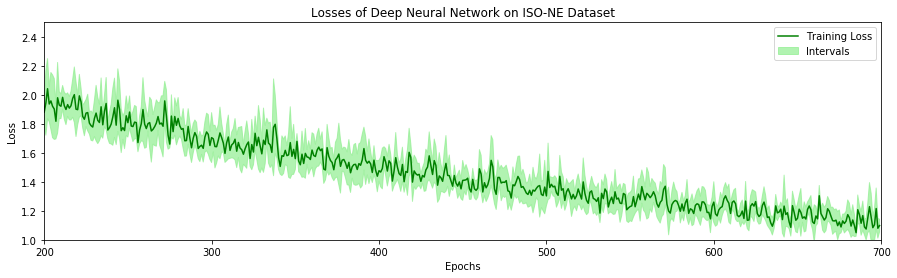

In [114]:
VAL = False # only used for the plotting section hereafter
# You can set the proportion of validation data in the training phase
# or split the data into training and validation sets in advance

if VAL:
    def get_curve_data(history):
        loss = []
        val_loss = []
        for history_item in history:
            loss = loss + history_item.history['loss']
            val_loss = val_loss + history_item.history['val_loss']
        return (np.array(loss), np.array(val_loss))
    
    loss_list = []
    val_loss_list = []
    for history in history_list:
        loss_once, val_loss_once = get_curve_data(history)
        loss_list.append(loss_once)
        val_loss_list.append(val_loss_once)
        
    loss = np.array(loss_list)
    val_loss = np.array(val_loss_list)
    
    loss_mean = np.mean(loss, axis=0)
    loss_std = np.std(loss, axis=0)
    loss_up = loss_mean + loss_std
    loss_down = loss_mean - loss_std
    
    val_loss_mean = np.mean(val_loss, axis=0)
    val_loss_std = np.std(val_loss, axis=0)
    val_loss_up = val_loss_mean + val_loss_std
    val_loss_down = val_loss_mean - val_loss_std
    
    x = range(700)
    
    plt.figure(figsize=(5, 4))
    plt.plot(x, loss_mean, color='Green')
    plt.fill_between(x, loss_up, loss_down, color='LightGreen', alpha=0.7) 
    plt.plot(val_loss_mean, color='RoyalBlue')
    plt.fill_between(x, val_loss_up, val_loss_down, color='LightSkyBlue', alpha=0.7) 
    plt.axis([200,700,1,2.5])
else:
    def get_curve_data(history):
        loss = []
        for history_item in history:
            loss = loss + history_item.history['loss']
        return (np.array(loss))
    
    loss_list = []
    for history in history_list:
        loss_once = get_curve_data(history)
        loss_list.append(loss_once)
        
    loss = np.array(loss_list)
    
    loss_mean = np.mean(loss, axis=0)
    loss_std = np.std(loss, axis=0)
    loss_up = loss_mean + loss_std
    loss_down = loss_mean - loss_std
    
    x = range(700)
    
    plt.figure(figsize=(15, 4))
    plt.plot(x, loss_mean, color='Green', label = 'Training Loss')
    plt.fill_between(x, loss_up, loss_down, color='LightGreen', alpha=0.7, label = 'Intervals') 
    plt.axis([200,700,1,2.5]) 
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Losses of Deep Neural Network on ISO-NE Dataset')
    plt.savefig('t.png')

In [42]:
mape

0.014759338845352632

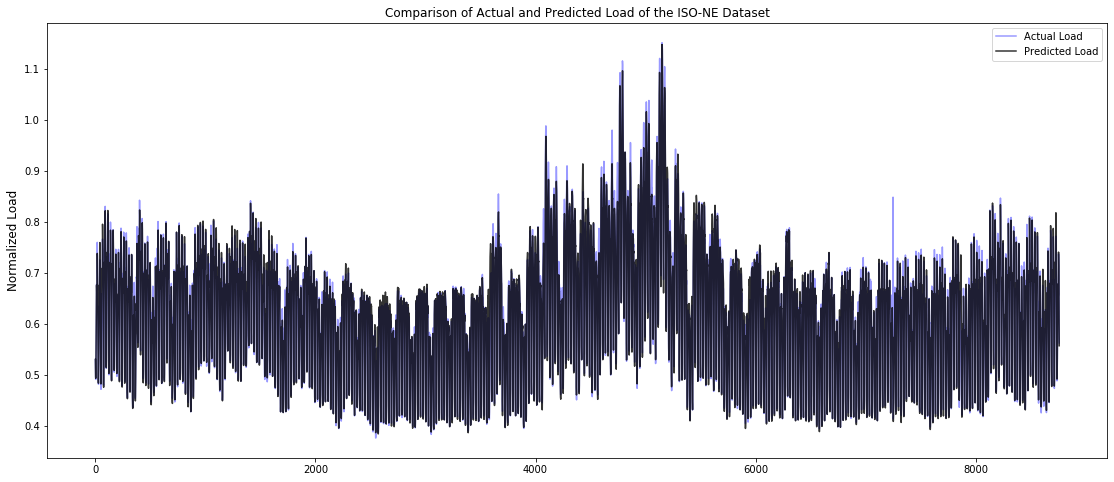

In [126]:
plt.figure(figsize = (19,8))

#plt.fill_between(x, loss_up, loss_down, color='LightGreen', alpha=0.7) 
plt.plot(Y_test_eval,  color = 'Blue', alpha = 0.4,label = 'Actual Load', )
plt.plot(pred_eval, alpha = 0.8,color = 'black', label = 'Predicted Load',)
plt.ylabel('Normalized Load', size =12)
plt.title('Comparison of Actual and Predicted Load of the ISO-NE Dataset')
plt.legend()
plt.savefig('Actual vs Predicted ISO-NE.png')